# DMASS tutorial

esutil and healpy should be installed 

In [2]:
#Y1 Data

import os, sys
import esutil
import healpy as hp
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
# call required functions from modules 
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS import priorCut_test

/users/PCON0003/warner785/DMASSY3/code_py3/run_DMASS.py:7: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


# Construct training samples

We first need to load Y3 Gold catalogs in the overlapping region (training region) and split them into the cmass sample and non-cmass sample. 

In [3]:
#correct catalogs:

# calling stripe82 gold catalogue -----------------------------
train_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/'
path =  train_path
train_keyword = 'Y1A1_GOLD_STRIPE82_v2'
    
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'EBV']

gold_st82 = io.SearchAndCallFits(path = train_path, columns = columns, keyword = train_keyword )
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]
    
print(gold_st82.size)


Calling catalogs >>>
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 1/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 2/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 3/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 4/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 5/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 6/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 7/8 /fs/scratch/PCON0003/warner785/bwarner/gold_ca

In [4]:
#implement Cuts.keepgoodregion:

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = LSSGoldmask['PIXEL']
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)

6768406


In [5]:
######
#more cuts on the gold data:
#SFD98 True for Y1

def RemovingSLRReddening(cat):


    if 'SLR_SHIFT_G' not in cat.dtype.names : 
        import numpy.lib.recfunctions as rf   
        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        from y1a1_slr_shiftmap import SLRShift
        zpfile = '/fs/scratch/PCON0003/warner785/bwarner/y1a1_wide_slr_wavg_zpshift2.fit'
        slrshift = SLRShift(zpfile, fill_periphery=True)
        offsets_g = slrshift.get_zeropoint_offset('g',cat['RA'],cat['DEC'],interpolate=True)
        offsets_r = slrshift.get_zeropoint_offset('r',cat['RA'],cat['DEC'],interpolate=True)
        offsets_i = slrshift.get_zeropoint_offset('i',cat['RA'],cat['DEC'],interpolate=True)
        offsets_z = slrshift.get_zeropoint_offset('z',cat['RA'],cat['DEC'],interpolate=True)

        offsets = [ offsets_g, offsets_r, offsets_i, offsets_z  ]
        from pandas import DataFrame, concat
        nametag = ['SLR_SHIFT_'+f for f in ['G', 'R', 'I', 'Z'] ]
        catnametag = cat.dtype.names
        try : 
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat, index = catnametag)
            #del cat['index']
            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
        
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping")
            
            #offsetsdf = np.array(offsetsdf).byteswap().newbyteorder()
            cat = np.array(cat).byteswap().newbyteorder()
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat)

            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
            cat.dtype.names = [str(x) for x in cat.dtype.names]
            
            #matched = pd.merge(desData, goldData, on=key, how=how, suffixes = suffixes, left_index=left_index)


    print('Removing SLR Shift ')
    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  removing SLR from ', mag)
        for b in ['G', 'R', 'I', 'Z']:
            cat[mag + '_'+b] = cat[mag + '_'+b] - cat['SLR_SHIFT'+ '_'+b]

    """
    cat = rf.append_fields(cat, 'SLR_SHIFT_G', offsets_g)
    cat = rf.append_fields(cat, 'SLR_SHIFT_R', offsets_r)
    cat = rf.append_fields(cat, 'SLR_SHIFT_I', offsets_i)
    cat = rf.append_fields(cat, 'SLR_SHIFT_Z', offsets_z)
    """
    return cat

In [6]:
def AddingSFD98Reddening(cat, kind='SPT', coeff = [3.186,2.140,1.569,1.196 ] ):
    import numpy.lib.recfunctions as rf
    import pandas as pd

    band = ['G', 'R', 'I', 'Z']

    if 'EBV' not in cat.dtype.names :   
     
        print('Using SFD98 nside 4096 healpix map')
        print('Bands :',  band)
        #print 'NSIDE = 4096'
        print('coefficients = ', coeff)
        nside = 4096

        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        #sfdfile = '/n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit'
        mapname = '/fs/scratch/PCON0003/warner785/bwarner/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
        #mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
        reddening_ring = hp.read_map(mapname)
        hpIndices = np.arange(reddening_ring.size)
        #goodmask = hp.mask_good(reddening_ring)
        #goldmask = 

        goodIndices = hpIndices #hpIndices[goodmask]
        clean_map = reddening_ring #reddening_ring[goodmask]

        sysMap = np.zeros((clean_map.size, ), dtype=[('PIXEL', 'i4'), ('EBV', 'f8'), ('RA', 'f8'), ('DEC', 'f8')])
        sysMap['PIXEL'] = goodIndices
        sysMap['EBV'] = clean_map
        
        sys_ra, sys_dec = hpHEALPixelToRaDec(goodIndices, nside = nside)
        sysMap['RA'] = sys_ra
        sysMap['DEC'] = sys_dec

        from cmass_modules.Cuts import keepGoodRegion
        sysMap = keepGoodRegion(sysMap)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]


        cat_hp = cat
        hpind = hpRaDecToHEALPixel(cat_hp['RA'], cat_hp['DEC'], nside= 4096, nest= False)
        #cat_hp.dtype.names = [str(x) for x in cat_hp.dtype.names]
        cat_hp = changeColumnName(cat_hp, name = 'HPIX', rename = 'PIXEL')
        cat_hp['PIXEL'] = hpind
        
        #sfdmap = changeColumnName( sysMap_ge, name = 'SIGNAL', rename = 'SFD98' )


        try : 

            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping ....")

            cat_hp = np.array(cat_hp).byteswap().newbyteorder()
            #sfdmap = np.array(sfdmap).byteswap().newbyteorder()
            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            

            #print cat_Data.keys()
            #print sfdData.keys()
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
            
        matched_arr = matched.to_records(index=False)
        matched_arr.dtype.names = [str(x) for x in matched_arr.dtype.names]


    else : matched_arr = cat

    print('Adding SFD98 Shift ')
    print('Bands :',  band)
    print('coefficients = ', coeff)

    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  Adding SFD to ', mag)
        for i,b in enumerate(band):
            matched_arr[mag + '_'+b] = matched_arr[mag + '_'+b] - matched_arr['EBV'] * coeff[i]    

    return matched_arr

In [7]:
params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_st82 = RemovingSLRReddening(gold_st82)
        gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]
    
print(gold_st82.size)

change reddening corrections from SLR to SFD98
Removing SLR Shift 
  removing SLR from  MAG_MODEL
  removing SLR from  MAG_DETMODEL
  removing SLR from  MAG_AUTO
Adding SFD98 Shift 
Bands : ['G', 'R', 'I', 'Z']
coefficients =  [3.186, 2.14, 1.569, 1.196]
  Adding SFD to  MAG_MODEL
  Adding SFD to  MAG_DETMODEL
  Adding SFD to  MAG_AUTO
CHECK input catalog has only galaxies
694475


Loading BOSS CMASS photometric sample

In [8]:
#this CMASS instead:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 13046


Now we find the CMASS galaxies in the DES Y3 GOLD catalog by matching positions of galaxies.  

In [9]:
# find cmass in des_gold side --------------------

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]


print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

('num of cmass in des side', 12639, '(5%)')


In [10]:
# save the samples. 
outdir = '../output/test/train_cat/y1/'
os.makedirs(outdir, exist_ok=True)
#esutil.io.write( outdir+'train_cmass_sample_sdss.fits', clean_cmass_data_sdss, overwrite=True)
esutil.io.write( outdir+'train_cmass_sample_des.fits', clean_cmass_data_des, overwrite=True)
esutil.io.write( outdir+'train_non_cmass_sample_des.fits', nocmass, overwrite=True)

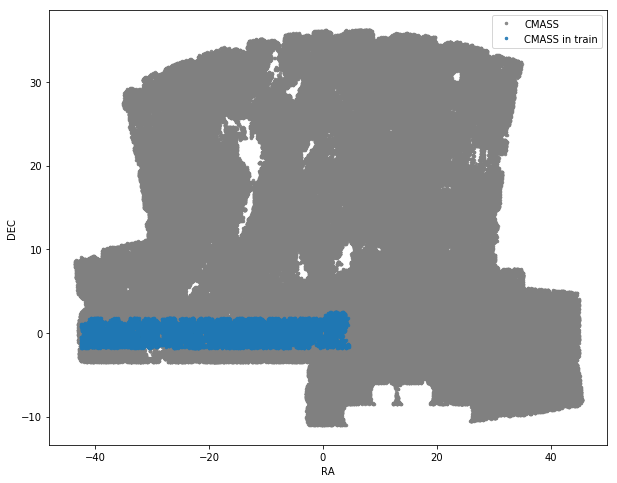

In [12]:
# Plotting footprint
spatialcheck([cmass, clean_cmass_data_des], 
             label = ['CMASS', 'CMASS in train'], convert = None, ratag='RA',dectag='DEC')

In [8]:
#Healpixels:



# Footprints of Train and Test regions

Codes for computing the areas of the training and test regions. 
This is not needed to run the DMASS algorithm. Only included this here as you asked before. 

In [13]:
# calling Y1 GOLD footprint map
# downloaded from https://cdcvs.fnal.gov/redmine/projects/des-y3/wiki/Y3A2_Gold_footprint
#mapname='/global/homes/b/bwarner/DMASS/code/y3a2_footprint_griz_1exp_v2.0.fits.gz.1'
mapname = '/fs/scratch/PCON0003/warner785/bwarner/Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
hpmap_y1gold = hp.read_map(mapname)
goodmask = hp.mask_good(hpmap_y1gold)
hpind_y1gold = np.arange(hpmap_y1gold.size)

# Generate mask for cmass
mask_train = np.in1d(cmass['HEALIndex'],hpind_y1gold[goodmask])

# Apply mask to extract cmass in the Y3 gold region
# This results 76722 CMASS galaxies
train_sample = cmass[mask_train]

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/fitsfunc.py:363: HealpixFitsWarning: No NSIDE in the header file : will use length of array
  "No NSIDE in the header file : will use length of array", HealpixFitsWarning


TypeError: unsupported format string passed to NoneType.__format__

In [14]:
# convert hp indices to ra/dec and split into st82 (training) and spt (test) regions. 
# Apply a rough cut (DEC > -10.0)
ra_hpmap_y1gold, dec_hpmap_y1gold = hpHEALPixelToRaDec( hpind_y1gold[goodmask], nside = 4096, nest=False )
mask_hpmap_y1gold_training = dec_hpmap_y1gold > -10.0
mask_hpmap_y1gold_testing = dec_hpmap_y1gold < -10.0

pixarea = hp.nside2pixarea( 4096, degrees = True)
npix_training =  np.sum(mask_hpmap_y1gold_training)
npix_testing = np.sum(mask_hpmap_y1gold_testing)
TrainingMapArea = pixarea * npix_training
TestingMapArea = pixarea * npix_testing
print ('<Survey Area> \n-This is a rough estimation')
print ('training region (dec > -10.0):{:5.0f} sq.deg'.format(TrainingMapArea) )
print ('testing region  (dec < -10.0):{:5.0f} sq.deg'.format(TestingMapArea) )

NameError: name 'hpind_y3gold' is not defined

# Training the algorithm

In [11]:
# call training samples
outdir = '../output/test/train_cat/y1/'
clean_cmass_data_des = esutil.io.read( outdir+'train_cmass_sample_des.fits')
nocmass = esutil.io.read( outdir+'train_non_cmass_sample_des.fits')

In [12]:
# For a fast run, we draw a random sample to reduce the sample size. 
# Larger sample tends to make a better model but the sample size is not always proportional to the accuracy of the model. 

# Put sample size you want 

n_sample = int(clean_cmass_data_des.size)  # train cmass sample size
n_sample_non = int(nocmass.size/20)          # train non-cmass sample size

#n_sample =  int(clean_cmass_data_des.size)  # train cmass sample size
#n_sample_non = int(nocmass.size/20)          # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_cmass_data_des.size), size = n_sample)
clean_cmass_data_des_sub = clean_cmass_data_des[sampling_ind]
print('num of randomly sampled cmass ', clean_cmass_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(nocmass.size), size = n_sample_non )
nocmass_sub = nocmass[random_sampling_ind]
print('num of randomly sampled non-cmass ', nocmass_sub.size)

# The fraction of CMASS galaxies in the training region.
# This number is required to put a prior for the Bayesian statistics 
cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
print('cmass_fraction (cmass/non-cmass): ', cmass_fraction)
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'cmassfrac', 'w')
f.write('{0:.10f}'.format(cmass_fraction))
f.close()

random sampling... 
num of randomly sampled cmass  100000
num of randomly sampled non-cmass  681836
cmass_fraction (cmass/non-cmass):  0.01819935922819396


### Model Fitting

In [13]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_cmass = None    # for cmass
n_no = None       # for non-cmass 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_cmass = 10  
n_iter_no = 1
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = '../output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
cmass_pickle = outdir+'gauss_cmass.pkl'
no_pickle = outdir+'gauss_no.pkl'

In [14]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MAG_DETMODEL', 'MAG_DETMODEL' ]
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [15]:
# Run XD Fitting. This will take a while 
clf_cmass = XD_fitting_X( X_cmass_true, X_cmass_cov, pickleFileName = cmass_pickle, 
                       n_cl = n_cmass, n_iter = n_iter_cmass, tol = tol, 
                       verbose = True, init_params= None)                 
clf_no = XD_fitting_X( X_no_true, X_no_cov, pickleFileName = no_pickle, 
                    n_cl = n_no, n_iter = n_iter_no, tol = tol, 
                    verbose = True, init_params = None)

@pickle_results: computing results and saving to '../output/test/fitting/gauss_cmass.pkl'
@pickle_results: computing results and saving to '../output/test/fitting/gauss_cmass.pkl.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  12


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


n components = 12
tolerance = 1e-05
1: log(L) = 375057.7833
    (8.8 sec)
2: log(L) = 375434.1995
    (9.1 sec)
3: log(L) = 375676.7109
    (9.4 sec)
4: log(L) = 375864.9164
    (9.6 sec)
5: log(L) = 376024.4242
    (9.1 sec)
6: log(L) = 376165.9649
    (8.9 sec)
7: log(L) = 376294.8699
    (9.6 sec)
8: log(L) = 376414.1145
    (9.5 sec)
9: log(L) = 376525.5084
    (9.6 sec)
10: log(L) = 376630.2345
    (9.9 sec)
elapsed time: 1.49 min,  total iteration 9                                 
@pickle_results: computing results and saving to '../output/test/fitting/gauss_no.pkl'
@pickle_results: computing results and saving to '../output/test/fitting/gauss_no.pkl.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  40


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


n components = 40
tolerance = 1e-05
1: log(L) = 1523927.903
    (1.9e+02 sec)
elapsed time: 0.00 min,  total iteration 0                                 


# Validation of the fitted XD model

In [4]:
# call saved pickles if you empty memory. Otherwise skip it 
outdir = '../output/test/fitting/'
cmass_pickle = outdir+'gauss_cmass.pkl'
no_pickle = outdir+'gauss_no.pkl'
clf_cmass = XD_fitting_X( None, None, pickleFileName = cmass_pickle)               
clf_no = XD_fitting_X( None, None, pickleFileName = no_pickle)

In [5]:
# We will generate a random sample from the fitted model and compare the resulting samples with the training sample
# If the model is correct, the random sample should match with the training sample
X_sample_cmass = clf_cmass.sample(200000)  # cmass model
X_sample_no = clf_no.sample(200000)        # non-cmass model

In [6]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_cmass_true, X_sample_cmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

NameError: name 'X_cmass_true' is not defined

Using central 100% to set range.


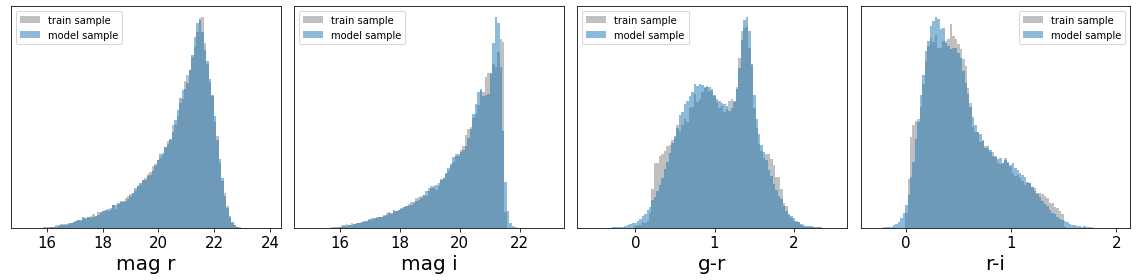

In [79]:
# Comparison. train vs. randoms for non-cmass
doVisualization_1d( data=[X_no_true, X_sample_no], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

If model samples agree with the training samples, we will use the fitted model to assign a CMASS membership probability to the Y3 Gold galaxies. First, try with the training region. As the model is trained with the training region, the assigned probability should reflect the color distributions of the taining galaxies. 

In [9]:
###FIGURE 3:

# For a fast run, we use a subset of y3 gold selected randomly.  
# Generate random indices, sample size 100,000

#rand_ind = np.random.choice(np.arange(gold_st82.size), size = 100000)
gold_st82_sub = fitsio.read('../output/test/train_cat/train_cmass_sample_des.fits')
#changed to cmass-matched in DES cat in st82

# Assigning CMASS probabilities to Gold Y3 in Stripe 82.
mag = ['MAG_DETMODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']
gold_st82_test = assignCMASSProb(gold_st82_sub, clf_cmass, clf_no, 
                     cmass_fraction = 0.006678648677551668
, 
                     mag=mag, err=err, filter=filter )

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


In [30]:
print(gold_st82_test.size)
print(gold_st82_test.dtype.names)
#np.histogram(gold_st82_test['CMASS_PROB'], bins=20)
pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram( gold_st82_test['CMASS_PROB'], bins=pbin)
print(pbin)

303
('COADD_OBJECT_ID', 'RA', 'DEC', 'HPIX_4096', 'SOF_CM_MAG_ERR_G', 'SOF_CM_MAG_ERR_R', 'SOF_CM_MAG_ERR_I', 'SOF_CM_MAG_ERR_Z', 'SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z', 'CMASS_PROB')
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


20
21
[0.10231023 0.04950495 0.04620462 0.05610561 0.05280528 0.06270627
 0.03630363 0.02970297 0.0330033  0.03960396 0.04290429 0.03630363
 0.05940594 0.05280528 0.03630363 0.02640264 0.04950495 0.0660066
 0.05280528 0.06930693]


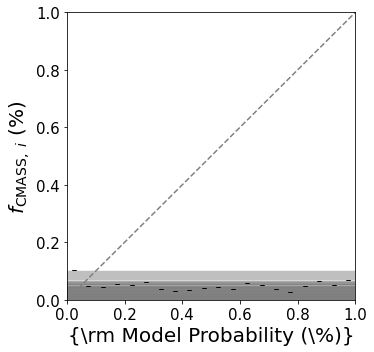

In [33]:
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/gold_st82_test.size
fracerr = np.zeros(20)

print(N.size)
print(pbin.size)
print(frac)

fig, ax = plt.subplots(figsize = (5.3,5))

ax.bar(pcenter, frac , 5, edgecolor='w',
        color='grey', yerr = fracerr, 
        alpha = 0.5, label = 'test', error_kw = {'elinewidth':0.01, 'capsize':2.4} )

ax.plot([0,1], [0,1], ls='--', color='grey')
ax.set_ylim(0,1)
ax.set_xlim(0,1)

ax.set_xlabel(r'{\rm Model Probability (\%)}', fontsize = 20)
ax.set_ylabel(r'$f_{ {\rm CMASS},~i}~(\%)$', fontsize = 20)
ax.tick_params(axis='both', labelsize = 15)
#ax.legend(loc='best', fontsize=15)
fig.tight_layout()
#fig.savefig('../paper_figure/model_probability.pdf')

The probability is saved into the `CMASS_PROB` column. `y3 gold` galaxies should be weighted with this column to be a DMASS galaxy. Now we will compare the color/magnitude distributions of the weighted `y3 gold` galaxies (DMASS) with the training sample

In [81]:
# Generate Four columns of data : mag r, mag i, (g-r), (r-i)
X_dmass_st82, Xcov = mixing_color(gold_st82_test, 
                mag = ['MAG_DETMODEL', 'MAG_DETMODEL'], 
                err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL'], 
                filter = ['G', 'R', 'I'],
                no_zband = True  )

Using central 100% to set range.


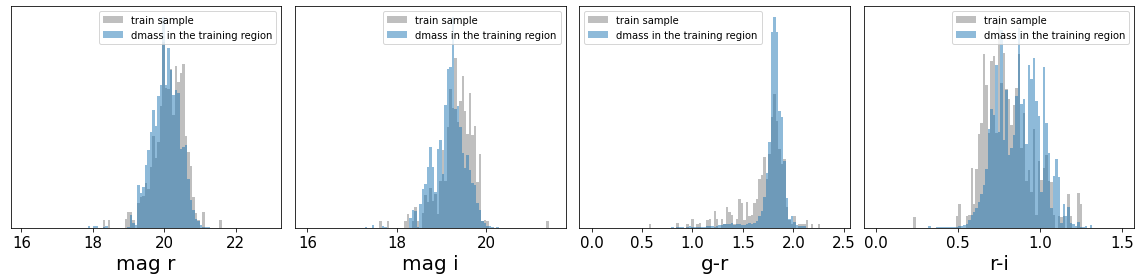

In [82]:
# Comparison plot for the training sample (cmass) vs. dmass sample selected in the training region
# DMASS sample should be weighted by 'CMASS_PROB' column when plotting
weight_dmass = gold_st82_test['CMASS_PROB']
doVisualization_1d( data=[X_cmass_true, X_dmass_st82], 
                   weight = [None, weight_dmass], # put DMASS weight here 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'dmass in the training region'], 
                   nbins=100)

# Apply the fitted model to galaxies outside the training region

If the fitted model works well in the training region, we will apply the model to `y3 gold` galaxies outside the training region. We call a small patch of `y3 gold` at `-40 < dec < -30`, `10 < ra < 20`. 

In [83]:
# empty memory 
gold_st82 = None
gold_st82_sub = None
nocmass = None

In [84]:
# Calling Y3 GOLD in a small square area 
input_path = '/fs/scratch/PCON0003/warner785/bwarner/'
input_keyword = 'Y3_GOLD_2_0_SPT_ra10_20'
columns = \
['RA', 'DEC', 'HPIX_4096', 
'COADD_OBJECT_ID', 
'SOF_CM_MAG_CORRECTED_G',
'SOF_CM_MAG_CORRECTED_R',
'SOF_CM_MAG_CORRECTED_I',
'SOF_CM_MAG_CORRECTED_Z',
'SOF_CM_MAG_ERR_G',
'SOF_CM_MAG_ERR_R',
'SOF_CM_MAG_ERR_I',
'SOF_CM_MAG_ERR_Z']
gold_spt = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Apply the same color/mag cuts to exclude extreme color/mag sources 
mask_magcut = priorCut_test(gold_spt)
gold_spt = gold_spt[mask_magcut]


Calling catalogs >>>
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000004.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000006.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000007.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000012.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000008.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000013.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000015.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000003.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000016.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000011.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000009.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000010.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000014.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000002.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000017.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000001.fits
Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000005.fits
reading 1/17 /global/cscratch1/sd/bwarner/Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000004.fits
reading 2/17 /global/cscratch1/sd/bwarner/Y3_GOLD_2_0_SPT_ra10_20_decm40_m30_000006.fits
r

In [85]:
# For a fast run, draw a random sample to reduce the sample size 
rand_ind = np.random.choice(np.arange(gold_spt.size), size = 100000)
gold_spt_sub = gold_spt[rand_ind]

# Assigning CMASS probabilities to Gold Y3
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'] 
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'] 
filter = ['G', 'R', 'I']
gold_spt_test = assignCMASSProb(gold_spt_sub, clf_cmass, clf_no, 
                     cmass_fraction = cmass_fraction, 
                     mag=mag, err=err, filter=filter )

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


In [86]:
X_dmass, Xcov = mixing_color(gold_spt_test, 
                mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED'], 
                err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR'], 
                filter = ['G', 'R', 'I'],
                no_zband = True  )

Using central 100% to set range.


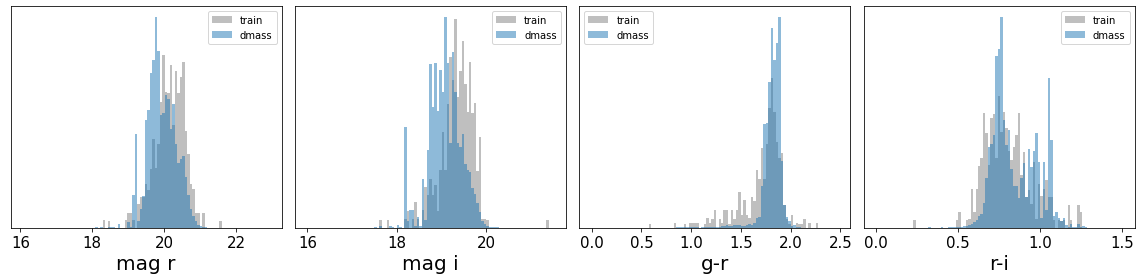

In [87]:
weight_dmass = gold_spt_test['CMASS_PROB']
doVisualization_1d(data=[X_cmass_true, X_dmass], 
                   weight = [None, weight_dmass],  # apply dmass weights
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train', 'dmass'], 
                   nbins=100)

In [88]:
#KS test:
from scipy import stats

#print(X_cmass_true.shape)
#print(X_dmass.shape)
#print(weight_dmass.shape)

#matching catalogs
#cuts to select RA and DEC

#numpy array slicing function 
#pass the first column etc.

Xdmass_magr=X_dmass[:,0]
Xdmass_magi=X_dmass[:,1]
Xdmass_gr=X_dmass[:,2]
Xdmass_ri=X_dmass[:,3]

Xcmass_magr=X_cmass_true[:,0]
Xcmass_magi=X_cmass_true[:,1]
Xcmass_gr=X_cmass_true[:,2]
Xcmass_ri=X_cmass_true[:,3]

print(Xdmass_magi.shape)
print(Xcmass_magr.shape)

stats.kstest(Xcmass_magr, Xdmass_magr)
stats.kstest(Xcmass_magi, Xdmass_magi)
stats.kstest(Xcmass_gr, Xdmass_gr)
stats.kstest(Xcmass_ri, Xdmass_ri)

#model training: make dist. match up more
#larger training set

######################################
#other notes:

#astro-coffee: once a week- depending on topic
#cosmology meeting Tuesday: 2pm-3pm (zoom)
#mailing list: subscribed?
#cosmolunch: present paper every so often

(100000,)
(100000,)


KstestResult(statistic=0.6279899999999999, pvalue=0.0)

In [ ]:
#create subsample:
#select all g-r values within an amount



In [37]:
#KS test sample (not same distribution):
from scipy import stats
#Arrays:
i=[0.125,0.375,0.375,0.5,0.5,0.875,1]
f=[0.285714,0.428571,0.714286,0.714286,0.857143,1,1]

stats.kstest(i,f)

KstestResult(statistic=0.42857142857142855, pvalue=0.5751748251748252)

In [38]:
#KS test sample 2 (same distribution):
from scipy import stats

m=[0.05, 0.1875, 0.25, 0.3375, 0.3375, 0.4, 0.5125, 0.675, 0.925, 1]
w=[0.112903, 0.177419, 0.193548, 0.370968, 0.564516, 0.629032, 0.66129, 0.725806, 0.854839, 1]

stats.kstest(m,w)

KstestResult(statistic=0.3, pvalue=0.7869297884777761)

(50000,)


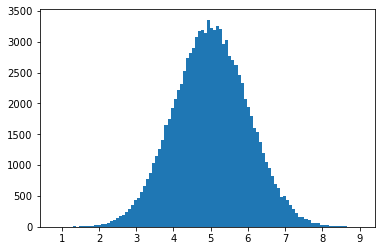

KstestResult(statistic=0.00384000000000001, pvalue=0.8532323035610377)

In [89]:
#data from the same distribution:
import numpy
import matplotlib.pyplot as plt
from scipy import stats

x = numpy.random.normal(5.0, 1.0, 100000)

#randomly select from array (twice):
x1=np.random.choice(x, 50000, replace=False)
x2=np.random.choice(x, 50000, replace=False)

print(x1.shape)
plt.hist(x, 100)
plt.show()

#check that ks test gives a correlation:
stats.kstest(x1,x2)

In [ ]:
#push to repo
#KS test by hand: double check 
#p value, X^2
#write out changing pieces
#main functions in code: input outputs-- Y3
####decide training set\validation set-- part of overlap data is only used for testing
#cross-validation of model while training
#decide once-- Su- what was considered during choice
#look at mock catalog-- Y3 realization of Y3 data-- mag. colors. simulated photo z-- use catalog and simulate DMASS by 
